Experimento 1
---

Simplemente entrenar con una (o mas) imagenes el algoritmo de regresi'on GlobalLinear (o cualquier otro de regresi'on que tena skit-learn). Con pares de patches en alta y baja resoluci'on (agarrando las imagenes ejemplo que viene con dipy (las alta resoluci'on) y downsampleandolas (las de baja resoluci'on).




In [1]:
%pylab inline

import dipy.reconst.dti as dti
import numpy as np
import nibabel as nib
import time

from experimento1_funciones import *
from utils.DataGetter import DataGetter
from utils.DownsampledImage import DownsampledImage
from utils.DmriSampleCreators import LrHrDmriRandomSampleCreator
from utils.dmri_patch_operations.LrHrPatchIterator import LrHrPatchIterator
from utils.dmri_patch_operations.DtiModel import DtiModel

from utils.ml.MLDataBuilder import SimpleDtiMlDataBuilder
from utils.persistance.MLPersistence import MLPersistence

from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib


/user/lgomez/home/anaconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [46]:
from utils.img_utils import _is, _isc, padding, column_this, _is3d
from utils.math_utils import mse_by_bval, normalize, normalize_by_bval

ImportError: cannot import name _is3d

In [3]:
def load_dmri(n_samples, n , m):
    try:
        N1 = (2 * n + 1) ** 3
        N2 = m ** 3

        d = DataGetter()
        datas_names = [
            DataGetter.STANDFORD_HARDI_DATA, #(81, 106, 76, 160)
            #DataGetter.TAIWAN_NTU_DSI_DATA,  #(96, 96, 60, 203)
            #DataGetter.SHERBROOKE_3SHELL_DATA #(128, 128, 60, 193)
        ]

        datas = d.get_data(datas_names)

        lr_hr_imgs = [DownsampledImage(name, datas[name]['img'], datas[name]['gtab'], m) for name in datas_names]
        print [(name, datas[name]['img'].shape) for name in datas_names]
        sample_creators = [LrHrDmriRandomSampleCreator(lr_hr_img, n, m) for lr_hr_img in lr_hr_imgs]
        sdb = SimpleDtiMlDataBuilder(sample_creators, n_samples);
        X, Y = sdb.build()
        print "X:", X.shape, "Y:", Y.shape
        return X, Y, lr_hr_imgs
    except Exception as e:
        print e;

In [7]:
def train(X, Y):
    # Split the data into training/testing sets
    dmri_X_train = X.T[:-1]
    dmri_X_test = X.T[-1:]

    # Split the targets into training/testing sets
    dmri_y_train = Y.T[:-1]
    dmri_y_test = Y.T[-1:]

    # Create linear regression object
    #regr = linear_model.LinearRegression()
    regr = linear_model.Ridge(alpha = .5)


    # Train the model using the training sets
    print 'Training set_training.shape=', dmri_X_train.T.shape, ' ->target.shape=', dmri_y_train.T.shape
    try:
        regr.fit(dmri_X_train, dmri_y_train)
    except RuntimeError as e:
        print e;
    return regr, dmri_X_train , dmri_y_train, dmri_X_test, dmri_y_test

Empiezo el experimento
---

Defino los parametros de patch n y m. Y cargo las imagenes de entrenamiento

In [4]:
name_experiment='experimento1'
n, m = 2, 2
n_samples = 559

X, Y, lr_hr_imgs = load_dmri(n_samples, n, m)

Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 
[('standfor_hardi', (81, 106, 76, 160))]
Samples for  standfor_hardi : 559 of 560
X: (750, 559) Y: (48, 559)


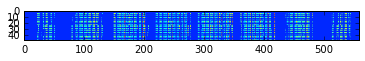

In [7]:
imshow(X)

In [8]:
regr = None#MLPersistence.load(name_experiment)
if regr is None or True:
    print 'hola'
    ## Entreno con todas las samples menos la ultima que la uso para test
    regr, dmri_X_train , dmri_y_train, dmri_X_test, dmri_y_test = train(X,Y)

    ## Guardo en archivo
    MLPersistence.save(regr, name_experiment)

    ## Impresion de variables del fiteo
    # The mean square error
    print("Residual sum of squares: %.2f" % np.mean((regr.predict(dmri_X_test) - dmri_y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(dmri_X_test, dmri_y_test))


hola
Training set_training.shape= (750, 558)  ->target.shape= (48, 558)
Residual sum of squares: 0.00
Variance score: 0.00


(48, 750) 0.000355718144327


(array([  2.70000000e+04,   0.00000000e+00,   5.00000000e+00,
          1.23700000e+03,   4.36000000e+03,   2.67800000e+03,
          5.37000000e+02,   1.38000000e+02,   3.60000000e+01,
          9.00000000e+00]),
 array([ -6.46200079e-06,   2.91098136e-05,   6.46816281e-05,
          1.00253443e-04,   1.35825257e-04,   1.71397071e-04,
          2.06968886e-04,   2.42540700e-04,   2.78112515e-04,
          3.13684329e-04,   3.49256144e-04]),
 <a list of 10 Patch objects>)

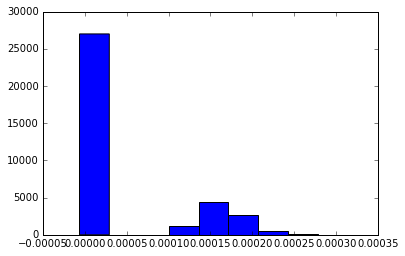

In [10]:
print regr.coef_.shape, regr.coef_.ptp()
#imshow(regr.coef_)
hist(regr.coef_.reshape(-1))

In [59]:
## Aca probar agarrar la chiquita y pasar a dti y luego a dwi

# DWI -> DTI
chiquita_dwi = lr_hr_imgs[0].get_lr_img()
gtab = lr_hr_imgs[0].get_gtab();
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(chiquita_dwi, mask=chiquita_dwi[..., 0] > 200)
chiquita_dti = tenfit.lower_triangular()

#hist(chiquita_dwi.reshape(-1))


In [66]:
#dti -> dwi
tenmodel2 = dti.TensorModel(gtab)
chiquita_tensors = dti.eig_from_lo_tri(chiquita_dti.astype(float))
s0 = chiquita_dwi[:,:,:,0]
chiquita_dwi2 = tenmodel2.predict(chiquita_tensors,s0)
print chiquita_tensors.shape, chiquita_dwi2.shape, chiquita_dwi.shape, chiquita_dwi.size

(41, 53, 38, 12) (41, 53, 38, 160) (41, 53, 38, 160) 13211840


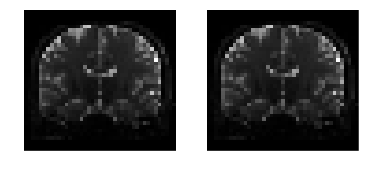

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [68]:
_isc(chiquita_dwi2, chiquita_dwi, 2, 0)

11443.9966998


(array([  5.74450000e+04,   1.18360000e+04,   1.05540000e+04,
          2.44600000e+03,   2.49000000e+02,   2.90000000e+01,
          8.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          3.00000000e+00]),
 array([   0.        ,   80.48450948,  160.96901896,  241.45352845,
         321.93803793,  402.42254741,  482.90705689,  563.39156638,
         643.87607586,  724.36058534,  804.84509482]),
 <a list of 10 Patch objects>)

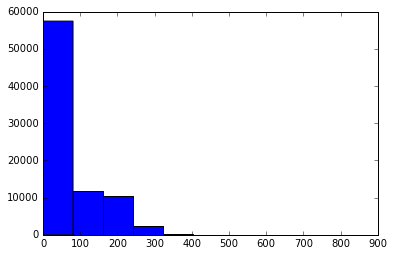

In [23]:
print chiquita_dwi2.ptp()
hist(chiquita_dwi2[:,:,:,12].reshape(-1))

In [8]:
ecm = normalize(mse_by_bval(chiquita_dwi,chiquita_dwi2))

NameError: name 'chiquita_dwi' is not defined

[ 0.31585491  0.31565121  0.31619684  0.31597094  0.31481408  0.31507144
  0.31608613  0.31392855  0.31524874  0.31395158  0.0062962   0.00646247
  0.00655361  0.00653175  0.006415    0.00665473  0.00649964  0.0066547
  0.0066364   0.0063569   0.00654609  0.00634248  0.00653004  0.00662994
  0.00630717  0.00637322  0.00628605  0.00645838  0.00648098  0.00644534
  0.00649917  0.00661751  0.0064056   0.00640866  0.00662205  0.00614104
  0.00645718  0.00673115  0.00648237  0.00617241  0.00619767  0.00609793
  0.00640305  0.00656648  0.00627266  0.00635133  0.00622742  0.00641845
  0.00642955  0.00608399  0.0063974   0.0063151   0.00655075  0.00651171
  0.00649201  0.00630344  0.00666732  0.0065785   0.00643301  0.00645655
  0.00626831  0.00642981  0.00628134  0.0064733   0.00621342  0.00640821
  0.00651763  0.00641544  0.00625614  0.00642288  0.00629205  0.00655953
  0.00627459  0.00661022  0.00640673  0.0064737   0.00644609  0.00670875
  0.00629676  0.00623308  0.00618002  0.00612839  0.

<Container object of 160 artists>

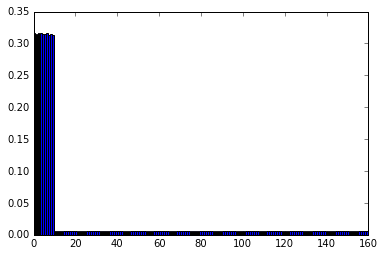

In [50]:
#imshow(chiquita_dwi[:,26,:, 100]-chiquita_dwi2[:,26,:, 100])
#colorbar()
print ecm
plt.bar(range(0,ecm.size), ecm)

In [9]:
del chiquita_dwi
del gtab
del tenmodel
del tenfit
del chiquita_dti
del chiquita_dwi2
del ecm

NameError: name 'chiquita_dwi' is not defined

('la chiquita', (45, 57, 42, 160))

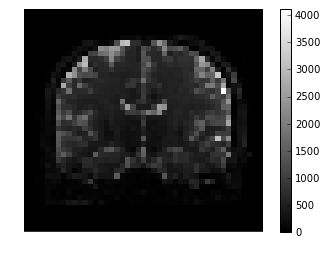

In [9]:
## Tomo una imagen para reconstruir
img_a_reconstruir = lr_hr_imgs[0];

## Hacerle el pading
img_lr = padding(img_a_reconstruir.get_lr_img(), 2)

_is(img_lr)
('la chiquita', img_lr.shape)

('la grandota', (81, 106, 76, 160))

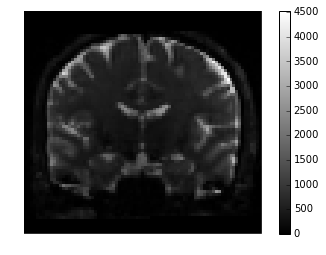

In [53]:
_is(img_a_reconstruir.get_hr_img())
('la grandota', img_a_reconstruir.get_hr_img().shape)

In [10]:
## Shape de las imagenes
img_hr_shape = img_a_reconstruir.get_hr_img().shape
img_lr_shape = img_lr.shape

## Armo el esqueleto de la dti-imagen
sx, sy, sz, _ = img_lr_shape
dti_img_hr = np.zeros((sx*m, sy*m, sz*m, 6), dtype='float');

## Creo un iterador sobre la imagen lr
it = LrHrPatchIterator(img_lr_shape, n, m)

img_hr_gtab = img_a_reconstruir.get_gtab();
dti_model = DtiModel(img_hr_gtab);
img_lr_dti = dti_model._fit_model(img_lr)

'img_lr_dti : ', img_lr_dti.shape

('img_lr_dti : ', (45, 57, 42, 6))

Ahora por cada patch de la imagen en baja resoluci'on a reconstruir (en su versi'on DTI), calculo los valores dti del pixel del centro en la imagen. Dicho pixel del centro en la imagen de baja resoluci'on se convierten en 8 pixeles en la imagen de alta resoluci'on equivalente.

In [11]:
sum=0;
start_time = time.time()
for data_ranges_lr_hr in it :
    sum=sum+1;

    # Indices en la imagen lr
    x0, xf, y0, yf, z0, zf = data_ranges_lr_hr['lr']

    # Fiteo el modelo del patch-lr (6 params dti)
    dti_patch_vol = img_lr_dti[x0:xf, y0:yf, z0:zf]

    x_vol = dti_patch_vol #dti_model.get_dti_params(dti_patch_vol)

    # Lo estructuro para que lo entienda ML (5,5,5,6) --> (1x750)
    x = column_this(x_vol)
    y = regr.predict(x.T)
    # Lo reestructuro (1,48) --> (2,2,2,6)
    dti_vol = y.reshape((2, 2, 2, 6))

    # Indices equivalentes en la imagen hr
    (a0, af, b0, bf, c0, cf) = data_ranges_lr_hr['hr']
    dti_img_hr[a0:af, b0:bf, c0:cf, :] = dti_vol

seg = time.time() - start_time
min = int(seg / 60)
print("--- time of predictions patchs : %d' %d'' --- num. iterations: %d" % (min , seg%60, sum))

--- time of predictions patchs : 0' 7'' --- num. iterations: 82574


In [12]:
del regr
del dmri_X_train
del dmri_y_train 
del dmri_X_test
del dmri_y_test 
del it
del dti_model
del img_lr_dti

El resultado de la regresi'on
---

In [13]:
# La corto porque tenia dimensiones de longitud impares
dti_img_hr = dti_img_hr[0:81,0:106,0:76, :]
print 'dti_img_hr=', dti_img_hr.shape

dti_img_hr= (81, 106, 76, 6)


ECM de todos los dti params de la imagen 
---

In [14]:
# Agarro la imagen original 
orig_dwi = lr_hr_imgs[0].get_hr_img()
gtab = lr_hr_imgs[0].get_gtab();

In [15]:
# Calculo dti de la imagen original
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(orig_dwi, mask=orig_dwi[..., 0] > 200)
orig_dti = tenfit.lower_triangular()

In [ ]:
# Calculo ecm de todos los voxels por parametro dti 
ecm = mse_by_bval(dti_img_hr, orig_dti)

0.713869083933


([<matplotlib.axis.XTick at 0x7f8d353ea2d0>,
 <a list of 6 Text xticklabel objects>)

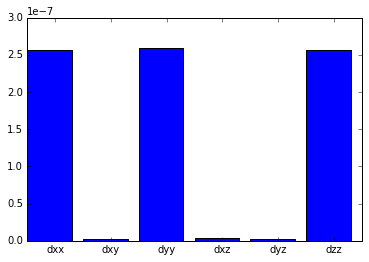

In [95]:
# Dibujo el ecm como grafico de barras
print np.linalg.norm(dti_img_hr-orig_dti)
plt.bar(range(0,ecm.size), ecm)
plt.xticks(arange(ecm.size)+0.5,('dxx','dxy','dyy','dxz','dyz','dzz'))

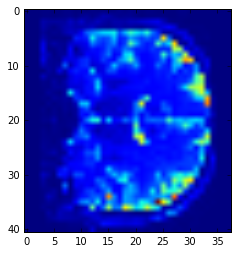

In [56]:
S0_lr = lr_hr_imgs[0].get_lr_img()[:,:,:,0]
imshow(S0_lr[:,S0_lr.shape[1]//2,:])


In [58]:
tenmodel = dti.TensorModel(img_a_reconstruir.get_gtab())
#tensors = dti.from_lower_triangular(dti_img_hr)
# (12 dti params --eval--evecs--)
tensors = dti.eig_from_lo_tri(dti_img_hr.astype(float))
img_recon_with_lrS0 = tenmodel.predict(tensors)


(81, 106, 76, 160)

In [ ]:
imshow()

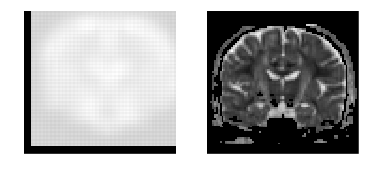

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [101]:
# Dibujo ecm como imagen
dxx=5
_isc(dti_img_hr,orig_dti,2, dxx)

Ecm por voxeles
---

In [18]:
#calculo ecm
ecm_img = ((dti_img_hr-orig_dti)**2).mean(axis=3)
print ecm_img.shape

(81, 106, 76)


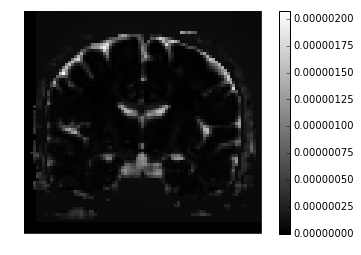

In [32]:
#Dibujo el resultado para ver donde hubo mas error (en la feta axial)
_is3d(ecm_img)

DTI --> DW-MRI (1)
---

Reconstruyo usando dipy

In [34]:
start_time = time.time()

st = time.time()
## Agarrar el fiteo y pasarlo a imagen
tenmodel = dti.TensorModel(img_a_reconstruir.get_gtab())
#tensors = dti.from_lower_triangular(dti_img_hr)
# (12 dti params --eval--evecs--)
tensors = dti.eig_from_lo_tri(dti_img_hr.astype(float))
img_reconstructed = tenmodel.predict(tensors)

seg = time.time() - st
min = int(seg / 60)
print("--- time of dipy dti : %d' %d'' --- " % (min , seg%60))

--- time of dipy dti : 0' 3'' --- 


In [105]:
print_info(img_reconstructed[:,:,:,12], 'img_reconstructed')

img_reconstructed : (min:max) 0.344246308669 : 1.0 ptp: 0.655753691331
#inf:  0 #-inf:  0  #Nan:  0
#uniques= 416621
histograma:
    #voxels:  [204354 361118      0      0      0      0      0      0      0  87064]
    valor:  [ 0.34424631  0.40982168  0.47539705  0.54097242  0.60654779  0.67212315
  0.73769852  0.80327389  0.86884926  0.93442463  1.        ]
dtype float64



2000.0


(array([ 218384.,  347088.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   87064.]),
 array([ 0.34396845,  0.40957161,  0.47517476,  0.54077792,  0.60638107,
         0.67198423,  0.73758738,  0.80319054,  0.86879369,  0.93439685,  1.        ]),
 <a list of 10 Patch objects>)

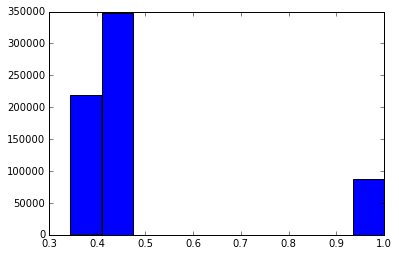

In [117]:
b_val = 15
print gtab.bvals[b_val]
hist(img_reconstructed[:,:,:,b_val].reshape(-1))

(81, 106, 76, 160)


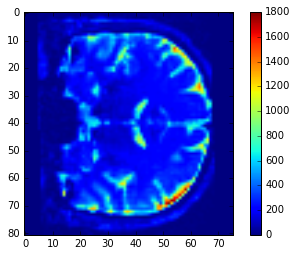

In [16]:
S0 = img_a_reconstruir.get_hr_img()[:,:,:,0]
print img_reconstructed.shape
imshow(np.multiply(img_reconstructed[:,53,:,12], S0[:,53,:]))
colorbar()

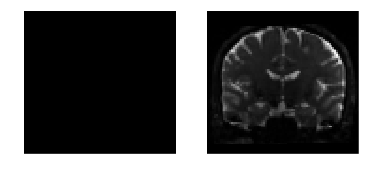

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [128]:
#_is(img_reconstructed)
_isc(img_reconstructed, img_a_reconstruir.get_hr_img())
img_reconstructed.shape

DTI --> DW-MRI (2)
---

Reconstruyo usando reconstruccion hecha por mi (multiplica la S0 original)

In [64]:
from utils.Dti2Dwi import Dti2Dwi

st = time.time()

dti2dwi = Dti2Dwi(dti_img_hr)
# S0 origina
S0 = img_a_reconstruir.get_hr_img()[:,:,:,0]
img_reconstructed2 = dti2dwi.predict(img_a_reconstruir.get_gtab(), S0)

seg = time.time() - st
min = int(seg / 60)
print("--- time of craft dti : %d' %d'' --- " % (min , seg%60))


--- time of craft dti : 9' 37'' --- 


(array([     0.,      0.,      0.,      0.,      0.,  36936.,      0.,
             0.,      0.,      0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

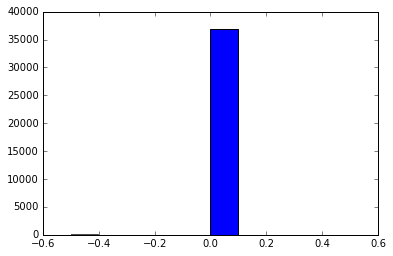

In [45]:
hist(dti_img_hr[:,5,:,:].reshape(-1))



img_reconstructed2 : (min:max) 0.0 : 13157.0 ptp: 13157.0
#inf:  0 #-inf:  0  #Nan:  0
#uniques= 5182
histograma:
    #voxels:  [616038  28177   6314   1580    265     96     37     19      9      1]
    valor:  [     0.    1315.7   2631.4   3947.1   5262.8   6578.5   7894.2   9209.9
  10525.6  11841.3  13157. ]
dtype float64



(array([  6.16038000e+05,   2.81770000e+04,   6.31400000e+03,
          1.58000000e+03,   2.65000000e+02,   9.60000000e+01,
          3.70000000e+01,   1.90000000e+01,   9.00000000e+00,
          1.00000000e+00]),
 array([     0. ,   1315.7,   2631.4,   3947.1,   5262.8,   6578.5,
          7894.2,   9209.9,  10525.6,  11841.3,  13157. ]),
 <a list of 10 Patch objects>)

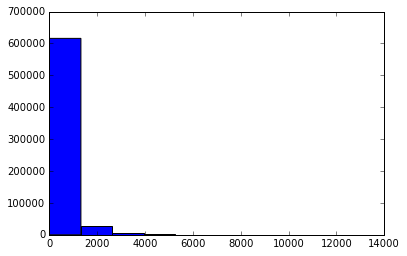

In [20]:
### la escalo entre 0 y 255
# img_reconstructed2 = (255.0/maximo) * img_reconstructed2

print_info(img_reconstructed2[:,:,:,0], 'img_reconstructed2')
hist(img_reconstructed2[:,:,:,0].reshape(-1))

2000.0


(array([  6.49921000e+05,   1.64000000e+03,   5.65000000e+02,
          2.14000000e+02,   9.50000000e+01,   4.90000000e+01,
          3.20000000e+01,   8.00000000e+00,   1.00000000e+01,
          2.00000000e+00]),
 array([    0. ,   252.2,   504.4,   756.6,  1008.8,  1261. ,  1513.2,
         1765.4,  2017.6,  2269.8,  2522. ]),
 <a list of 10 Patch objects>)

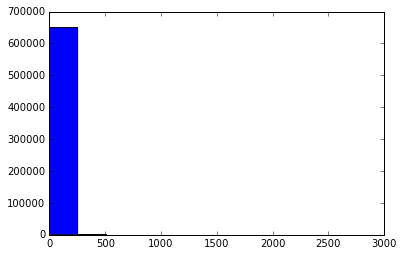

In [132]:
b_val = 15
print gtab.bvals[b_val]
hist(img_reconstructed2[:,:,:,b_val].reshape(-1))

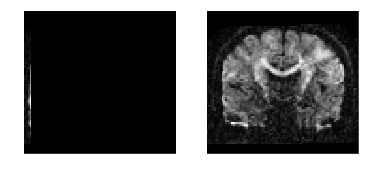

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [139]:
_isc(img_reconstructed2, img_a_reconstruir.get_hr_img(), 2, 15)
img_reconstructed2.shape

DTI --> DW-MRI (3)
---

Reconstruyo usando reconstruccion (1) multiplica la S0 original.

In [17]:
st = time.time()

img_reconstructed3 = np.zeros((img_reconstructed.shape), dtype='float')
sx, sy, sz , _ = img_reconstructed.shape
for i in range(0, sx):
    for j in range(0, sy):
        for k in range(0, sz):
            img_reconstructed3[i,j,k,:] = S0[i][j][k] * img_reconstructed[i,j,k,:]

seg = time.time() - st
min = int(seg / 60)
print("--- time of dipy*S0 : %d' %d'' --- " % (min , seg%60))


--- time of dipy*S0 : 0' 3'' --- 


img_reconstructed3 : (min:max) 0.0 : 13157.0 ptp: 13157.0
#inf:  0 #-inf:  0  #Nan:  0
#uniques= 5182
histograma:
    #voxels:  [616038  28177   6314   1580    265     96     37     19      9      1]
    valor:  [     0.    1315.7   2631.4   3947.1   5262.8   6578.5   7894.2   9209.9
  10525.6  11841.3  13157. ]
dtype float64



(array([  6.16038000e+05,   2.81770000e+04,   6.31400000e+03,
          1.58000000e+03,   2.65000000e+02,   9.60000000e+01,
          3.70000000e+01,   1.90000000e+01,   9.00000000e+00,
          1.00000000e+00]),
 array([     0. ,   1315.7,   2631.4,   3947.1,   5262.8,   6578.5,
          7894.2,   9209.9,  10525.6,  11841.3,  13157. ]),
 <a list of 10 Patch objects>)

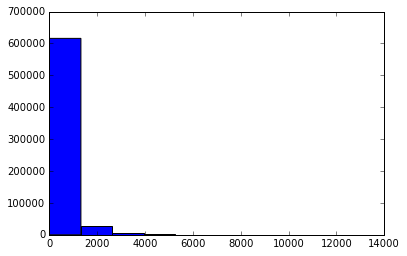

In [23]:
print_info(img_reconstructed3[:,:,:,0], 'img_reconstructed3')
hist(img_reconstructed3[:,:,:,0].reshape(-1))

0.0


(array([  6.16038000e+05,   2.81770000e+04,   6.31400000e+03,
          1.58000000e+03,   2.65000000e+02,   9.60000000e+01,
          3.70000000e+01,   1.90000000e+01,   9.00000000e+00,
          1.00000000e+00]),
 array([     0. ,   1315.7,   2631.4,   3947.1,   5262.8,   6578.5,
          7894.2,   9209.9,  10525.6,  11841.3,  13157. ]),
 <a list of 10 Patch objects>)

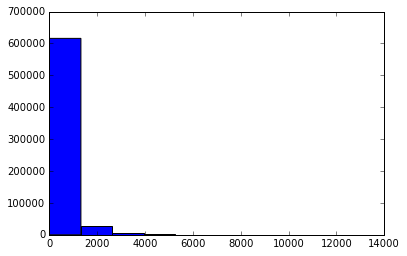

In [144]:
b_val = 0
print gtab.bvals[b_val]
hist(img_reconstructed3[:,:,:,b_val].reshape(-1))

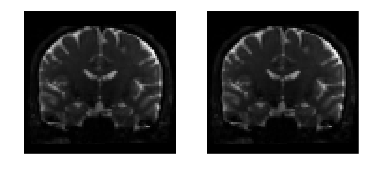

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [146]:
_isc(img_reconstructed3, img_a_reconstruir.get_hr_img(), 2, 0)
img_reconstructed2.shape

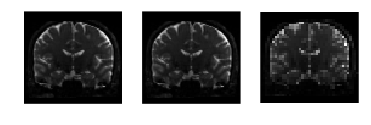

(81, 106, 76, 160)

In [54]:
_isc3(img_reconstructed3, img_a_reconstruir.get_hr_img(), img_a_reconstruir.get_lr_img())
img_reconstructed3.shape

DTI --> DW-MRI (4)
---

Reconstruyo usando de dipy pasandole la S0 original.

In [36]:
st = time.time()

img_reconstructed4 = tenmodel.predict(tensors, S0)

seg = time.time() - st
min = int(seg / 60)
print("--- time of dipy*S0 : %d' %d'' --- " % (min , seg%60))


/user/lgomez/home/anaconda2/lib/python2.7/site-packages/dipy/reconst/dti.py:1759: RuntimeWarning: divide by zero encountered in log
  D[..., 6] = -np.log(b0)


--- time of dipy*S0 : 0' 5'' --- 


img_reconstructed4 : (min:max) 0.0 : 13156.994351 ptp: 13156.994351
#inf:  0 #-inf:  0  #Nan:  0
#uniques= 5182
histograma:
    #voxels:  [616038  28177   6314   1580    265     96     37     19      9      1]
    valor:  [     0.           1315.6994351    2631.3988702    3947.09830529
   5262.79774039   6578.49717549   7894.19661059   9209.89604568
  10525.59548078  11841.29491588  13156.99435098]
dtype float64



(array([  6.16038000e+05,   2.81770000e+04,   6.31400000e+03,
          1.58000000e+03,   2.65000000e+02,   9.60000000e+01,
          3.70000000e+01,   1.90000000e+01,   9.00000000e+00,
          1.00000000e+00]),
 array([     0.        ,   1315.6994351 ,   2631.3988702 ,   3947.09830529,
          5262.79774039,   6578.49717549,   7894.19661059,   9209.89604568,
         10525.59548078,  11841.29491588,  13156.99435098]),
 <a list of 10 Patch objects>)

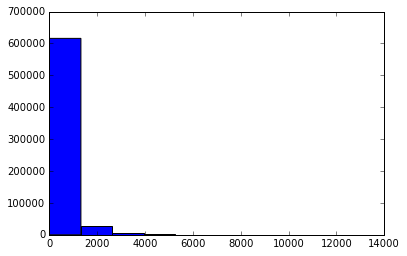

In [24]:
print_info(img_reconstructed4[:,:,:,0], 'img_reconstructed4')
hist(img_reconstructed4[:,:,:,0].reshape(-1))

2000.0


(array([  6.19578000e+05,   2.62820000e+04,   5.26700000e+03,
          1.09800000e+03,   1.86000000e+02,   6.60000000e+01,
          3.50000000e+01,   1.40000000e+01,   9.00000000e+00,
          1.00000000e+00]),
 array([    0.        ,   566.87136088,  1133.74272176,  1700.61408264,
         2267.48544352,  2834.3568044 ,  3401.22816527,  3968.09952615,
         4534.97088703,  5101.84224791,  5668.71360879]),
 <a list of 10 Patch objects>)

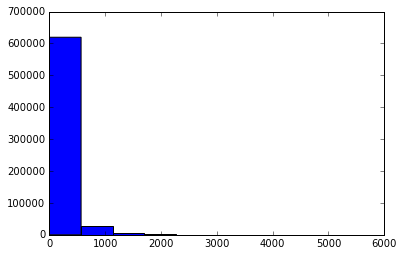

In [150]:
b_val = 15
print gtab.bvals[b_val]
hist(img_reconstructed4[:,:,:,b_val].reshape(-1))

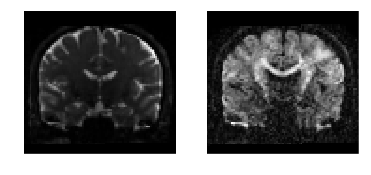

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [152]:
#_isc3(img_reconstructed4, img_a_reconstruir.get_hr_img(), img_a_reconstruir.get_lr_img())
_isc(img_reconstructed4, img_a_reconstruir.get_hr_img(),2, 15)
img_reconstructed4.shape

ECM por voxel de la reconstruccion 4
---

In [47]:
ecm4_img = ((orig_dwi-img_reconstructed4)**2).mean(axis=3)
print ecm4_img.shape

(81, 106, 76)


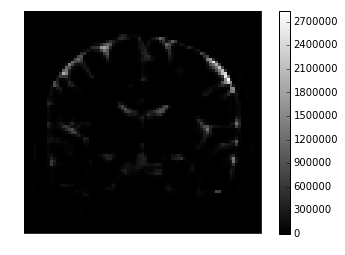

In [48]:
# Dibujo el ecm por voxel de los dwi
_is3d(ecm4_img)

ECM por voxel agrupado por b-val
---

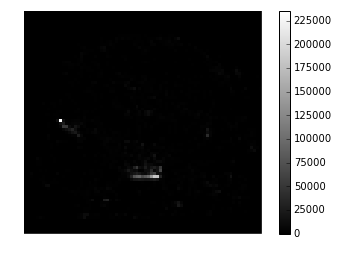

In [49]:
# Con b-val=0
ecm4_img_b0 = ((orig_dwi[:,:,:,0:10]-img_reconstructed4[:,:,:,0:10])**2).mean(axis=3)
_is3d(ecm4_img_b0)

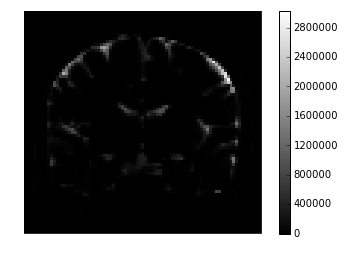

In [52]:
# Con b-val=2000
ecm4_img_b0 = ((orig_dwi[:,:,:,10:]-img_reconstructed4[:,:,:,10:])**2).mean(axis=3)
_is3d(ecm4_img_b0)


Comparando resultados 
---

Normalizo todas para estar en la misma escala de representaci'on


In [19]:
img_lr_orig = img_a_reconstruir.get_hr_img()

In [25]:
img_lr_orig_norm = normalize_by_bval(img_lr_orig.astype(float))
print 'max:min (', np.min(img_lr_orig_norm), ':', np.max(img_lr_orig_norm), ')' 

maximo valor antes de normalizar : 13321.0
max:min ( 0.0 : 1.0 )


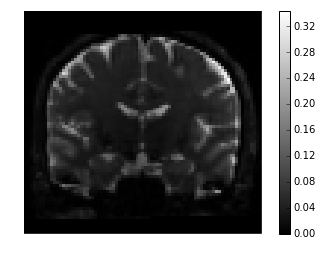

In [27]:
_is(img_lr_orig_norm)

ECM con la 4
---

In [28]:
img4norm = normalize_by_bval(img_reconstructed4)

maximo valor antes de normalizar : 13156.994351


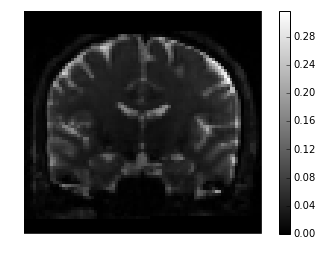

In [30]:
_is(img4norm, 2, 15)

In [32]:
means4 = mse_by_bval(img4norm, img_lr_orig_norm)

<Container object of 20 artists>

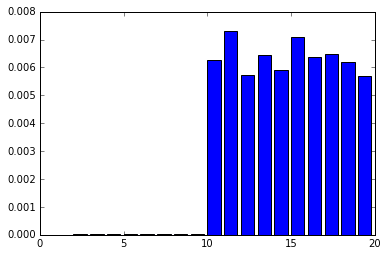

In [36]:
plt.bar(arange(20), means4[0:20])
#plt.xticks(arange(20), img_a_reconstruir.gtab.bvals[0:20])

(array([  10.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  150.]),
 array([  5.68402800e-20,   1.71999098e-07,   3.43998195e-07,
          5.15997293e-07,   6.87996390e-07,   8.59995488e-07,
          1.03199459e-06,   1.20399368e-06,   1.37599278e-06,
          1.54799188e-06,   1.71999098e-06]),
 <a list of 10 Patch objects>)

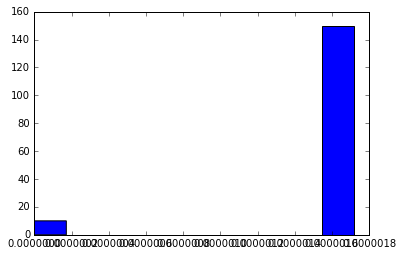

In [37]:
plt.hist(means4)


ECM con la 3
---

In [42]:
#del means4
import gc
gc.collect()

116

maximo valor antes de normalizar : 13157.0


<Container object of 20 artists>

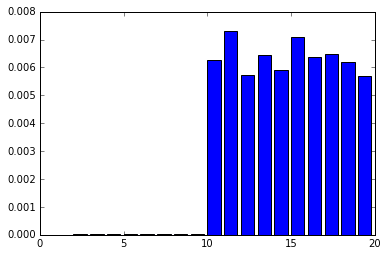

In [44]:
img3norm = normalize_by_bval(img_reconstructed3)
means3 = mse_by_bval(img3norm, img_lr_orig_norm)
plt.bar(arange(20), means3[0:20]) 

ECM con la 2
---

maximo valor antes de normalizar : 13157.0


<Container object of 20 artists>

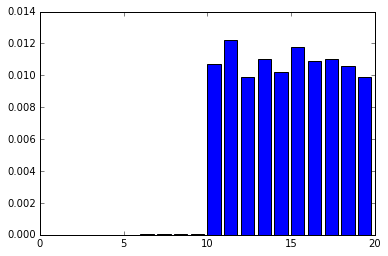

In [67]:
gc.collect()

img2norm = normalize_by_bval(img_reconstructed2)
means2 = mse_by_bval(img2norm, img_lr_orig_norm)
plt.bar(arange(20), means2[0:20]) 

ECM con la 1
---

In [46]:
img1norm = normalize_by_bval(img_reconstructed)

maximo valor antes de normalizar : 1.0


NameError: name 'means1' is not defined

<Container object of 20 artists>

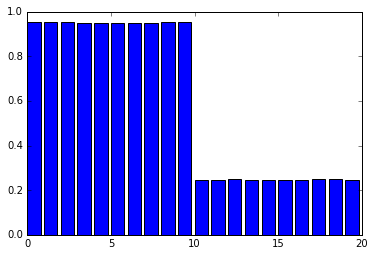

In [47]:
means1 = mse_by_bval(img1norm, img_lr_orig_norm)
plt.bar(arange(20), means1[0:20])

In [49]:
del means1
del means3
gc.collect()

79